<a href="https://colab.research.google.com/github/kridtapon/StoBoll-Optimizer/blob/main/StoBoll_Optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.4/527.4 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: numba
    Found existing installation: numba 0.60.0
    Uninstalling numba-0.60.0:
      Successfully uninst

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import matplotlib.pyplot as plt

# Calculate Stochastic Oscillator
def calculate_stochastic_oscillator(df, k_period=14, d_period=3):
    """Calculate the Stochastic Oscillator."""
    df['Low_K'] = df['Low'].rolling(window=k_period).min()
    df['High_K'] = df['High'].rolling(window=k_period).max()
    df['%K'] = (df['Close'] - df['Low_K']) / (df['High_K'] - df['Low_K']) * 100
    df['%D'] = df['%K'].rolling(window=d_period).mean()
    return df

# Calculate Bollinger Bands
def calculate_bollinger_bands(df, window=20, num_std_dev=2):
    """Calculate Bollinger Bands."""
    df['BB_Middle'] = df['Close'].rolling(window=window).mean()
    df['BB_Upper'] = df['BB_Middle'] + num_std_dev * df['Close'].rolling(window=window).std()
    df['BB_Lower'] = df['BB_Middle'] - num_std_dev * df['Close'].rolling(window=window).std()
    return df

# Define the stock symbol and time period
symbol = '^FTSE'
start_date = '2015-01-01'
end_date = '2024-12-31'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Calculate indicators
df = calculate_stochastic_oscillator(df,2,1)
df = calculate_bollinger_bands(df,12,1.5)

# Define entry and exit signals based on Stochastic Oscillator and Bollinger Bands
# Entry condition: Stochastic %K crosses above 20 and Close is below lower Bollinger Band
df['Entry'] = (
    (df['%K'] > 20) &
    (df['%K'].shift(1) <= 20) &
    (df['Close'] < df['BB_Lower'])
)

# Exit condition: Stochastic %K crosses below 80 and Close is near or above upper Bollinger Band
df['Exit'] = (
    (df['%K'] < 80) &
    (df['%K'].shift(1) >= 80) &
    (df['Close'] >= df['BB_Upper'])
)

# Convert signals to boolean arrays
entries = df['Entry'].to_numpy()
exits = df['Exit'].to_numpy()

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=entries,
    exits=exits,
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



Start                         2015-01-02 00:00:00
End                           2024-12-30 00:00:00
Period                                       2524
Start Value                              100000.0
End Value                            247435.17509
Total Return [%]                       147.435175
Benchmark Return [%]                    24.026394
Max Gross Exposure [%]                      100.0
Total Fees Paid                       8759.443322
Max Drawdown [%]                        29.159943
Max Drawdown Duration                       283.0
Total Trades                                   28
Total Closed Trades                            27
Total Open Trades                               1
Open Trade PnL                         3192.84928
Win Rate [%]                            88.888889
Best Trade [%]                          13.902333
Worst Trade [%]                        -10.145318
Avg Winning Trade [%]                    4.776718
Avg Losing Trade [%]                    -6.760351


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
from itertools import product

# Calculate Stochastic Oscillator
def calculate_stochastic_oscillator(df, k_period=14, d_period=3):
    df['Low_K'] = df['Low'].rolling(window=k_period).min()
    df['High_K'] = df['High'].rolling(window=k_period).max()
    df['%K'] = (df['Close'] - df['Low_K']) / (df['High_K'] - df['Low_K']) * 100
    df['%D'] = df['%K'].rolling(window=d_period).mean()
    return df

# Calculate Bollinger Bands
def calculate_bollinger_bands(df, window=20, num_std_dev=2):
    df['BB_Middle'] = df['Close'].rolling(window=window).mean()
    df['BB_Upper'] = df['BB_Middle'] + num_std_dev * df['Close'].rolling(window=window).std()
    df['BB_Lower'] = df['BB_Middle'] - num_std_dev * df['Close'].rolling(window=window).std()
    return df

# Backtest function
def backtest_strategy(df, k_period, d_period, window, num_std_dev):
    df = calculate_stochastic_oscillator(df.copy(), k_period=k_period, d_period=d_period)
    df = calculate_bollinger_bands(df, window=window, num_std_dev=num_std_dev)

    df['Entry'] = (
        (df['%K'] > 20) &
        (df['%K'].shift(1) <= 20) &
        (df['Close'] < df['BB_Lower'])
    )

    df['Exit'] = (
        (df['%K'] < 80) &
        (df['%K'].shift(1) >= 80) &
        (df['Close'] >= df['BB_Upper'])
    )

    entries = df['Entry'].to_numpy()
    exits = df['Exit'].to_numpy()

    portfolio = vbt.Portfolio.from_signals(
        close=df['Close'],
        entries=entries,
        exits=exits,
        init_cash=100_000,
        fees=0.001
    )

    return portfolio.total_return()

# Define the stock symbol and time period
symbol = '^FTSE'
start_date = '2015-01-01'
end_date = '2024-12-31'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Parameter grid
k_periods = range(1,50)
d_periods = range(1,50)
windows = range(1,50)
num_std_devs = [1.5, 2, 2.5]

# Grid search
best_params = None
best_return = -np.inf

for k_period, d_period, window, num_std_dev in product(k_periods, d_periods, windows, num_std_devs):
    total_return = backtest_strategy(df, k_period, d_period, window, num_std_dev)

    if total_return > best_return:
        best_return = total_return
        best_params = (k_period, d_period, window, num_std_dev)

# Print best parameters and return
print(f"Best Parameters: k_period={best_params[0]}, d_period={best_params[1]}, window={best_params[2]}, num_std_dev={best_params[3]}")
print(f"Best Total Return: {best_return:.2f}")


[*********************100%***********************]  1 of 1 completed


Best Parameters: k_period=2, d_period=1, window=12, num_std_dev=1.5
Best Total Return: 1.47


In [1]:
pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.7 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


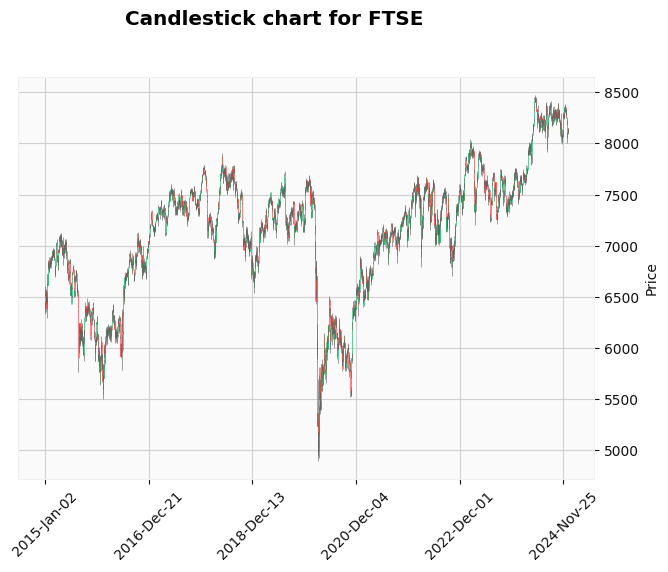

In [3]:
import yfinance as yf
import mplfinance as mpf

# Define the stock symbol and time period
symbol = '^FTSE'
start_date = '2015-01-01'
end_date = '2024-12-31'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)

# Adjust column names for mplfinance
df.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
df.dropna(inplace=True)

# Plot the candlestick chart
mpf.plot(df, type='candle', title=f'Candlestick chart for FTSE', style='yahoo')


In [1]:
import vectorbt as vbt
import pandas as pd

In [7]:
df=df['Close']
pf = vbt.Portfolio.from_holding(df, init_cash=100)
pf.total_profit()

24.02639424293733

In [8]:
pf.stats()

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'sharpe_ratio' requires frequency to be set
  warnings.warn(warning_message)
/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'calmar_ratio' requires frequency to be set
  warnings.warn(warning_message)
/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'omega_ratio' requires frequency to be set
  warnings.warn(warning_message)
/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'sortino_ratio' requires frequency to be set
  warnings.warn(warning_message)


,Close
Start,2015-01-02 00:00:00
End,2024-12-30 00:00:00
Period,2524
Start Value,100.0
End Value,124.026394
Total Return [%],24.026394
Benchmark Return [%],24.026394
Max Gross Exposure [%],100.0
Total Fees Paid,0.0
Max Drawdown [%],36.605523
